# Our model with metric loss

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
from __future__ import print_function
import argparse
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from triplet_mnist_loader import MNIST_t
import torch.nn.functional as F

batch_size = 120
epochs = 10
no_cuda = False
seed = 1
log_interval = 50
margin = 0.2
cuda = not no_cuda and torch.cuda.is_available()


torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)


kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
        MNIST_t('../data', train=True, download=True,
                       transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
        MNIST_t('../data', train=False, download=True,
                       transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True, **kwargs)


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if cuda:
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        x = x.view(-1, 784)
        h1 = self.relu(self.fc1(x))
        mu = self.fc21(h1)
        logvar = self.fc22(h1)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE()
if cuda:
    model.cuda()

reconstruction_function = nn.BCELoss()
reconstruction_function.size_average = False


def loss_function(recon_x, x, mu, logvar):
    BCE = reconstruction_function(recon_x, x)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)

    return BCE + KLD


optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MarginRankingLoss(margin = margin)


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def accuracy(dista, distb):
    margin = 0
    pred = (dista - distb - margin).cpu().data
    return (pred > 0).sum()*1.0/dista.size()[0]

train_loss_metric = []
train_loss_VAE = []
train_acc_metric = []
test_loss_metric = []
test_loss_VAE = []
test_acc_metric = []

for epoch in range(1, epochs + 1):
    losses_metric = AverageMeter()
    losses_VAE = AverageMeter()
    accs = AverageMeter()
    emb_norms = AverageMeter()

    model.train()
    for batch_idx, (data1, data2, data3) in enumerate(train_loader):
        if cuda:
            data1, data2, data3 = data1.cuda(), data2.cuda(), data3.cuda()
        data1, data2, data3 = Variable(data1), Variable(data2), Variable(data3)

        recon_batch1, mu1, logvar1 = model(data1)
        recon_batch2, mu2, logvar2 = model(data2)
        recon_batch3, mu3, logvar3 = model(data3)

        loss_vae = loss_function(recon_batch1, data1, mu1, logvar1)     
        loss_vae += loss_function(recon_batch2, data2, mu2, logvar2)  
        loss_vae += loss_function(recon_batch3, data3, mu3, logvar3)  
        loss_vae = loss_vae/(3*len(data1))

        dista = F.pairwise_distance(mu1, mu2, 2)
        distb = F.pairwise_distance(mu1, mu3, 2)
        target = torch.FloatTensor(dista.size()).fill_(1)
        if cuda:
            target = target.cuda()
        target = Variable(target)
        loss_triplet = criterion(dista, distb, target)

        loss_embedd = mu1.norm(2) + mu2.norm(2) + mu3.norm(2)

        loss = 0.01*loss_vae + loss_triplet + 0.001*loss_embedd

        # measure accuracy and record loss
        acc = accuracy(dista, distb)
        losses_metric.update(loss_triplet.data[0], data1.size(0))
        losses_VAE.update(loss_vae.data[0], data1.size(0))
        accs.update(acc, data1.size(0))
        emb_norms.update(loss_embedd.data[0]/3, data1.size(0))

        # train
        optimizer.zero_grad()          
        loss.backward()
        optimizer.step()  
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{}]\t'
                  'VAE Loss: {:.4f} ({:.4f}) \t'
                  'Metric Loss: {:.4f} ({:.4f}) \t'
                  'Metric Acc: {:.2f}% ({:.2f}%) \t'
                  'Emb_Norm: {:.2f} ({:.2f})'.format(
                epoch, batch_idx * len(data1), len(train_loader.dataset),
                losses_VAE.val, losses_VAE.avg,
                losses_metric.val, losses_metric.avg, 
                100. * accs.val, 100. * accs.avg, emb_norms.val, emb_norms.avg))

            train_loss_metric.append(losses_metric.val)
            train_loss_VAE.append(losses_VAE.val)
            train_acc_metric.append(accs.val)

           # plot(data1, recon_batch1, recon_batch1)
            data_metric_train = data1
            recon_batch_metric_train = recon_batch1

            # Test
            model.eval()
            model_vanilla.eval()
            for batch_idx, (data1, data2, data3) in enumerate(test_loader):
                if cuda:
                    data1, data2, data3 = data1.cuda(), data2.cuda(), data3.cuda()
                data1, data2, data3 = Variable(data1), Variable(data2), Variable(data3)

                recon_batch1, mu1, logvar1 = model(data1)
                recon_batch2, mu2, logvar2 = model(data2)
                recon_batch3, mu3, logvar3 = model(data3)

                loss_vae = loss_function(recon_batch1, data1, mu1, logvar1)     
                loss_vae += loss_function(recon_batch2, data2, mu2, logvar2)  
                loss_vae += loss_function(recon_batch3, data3, mu3, logvar3)  
                loss_vae = loss_vae/(3*len(data1))

                dista = F.pairwise_distance(mu1, mu2, 2)
                distb = F.pairwise_distance(mu1, mu3, 2)
                target = torch.FloatTensor(dista.size()).fill_(1)
                if cuda:
                    target = target.cuda()
                target = Variable(target)
                loss_triplet = criterion(dista, distb, target)

                loss_embedd = mu1.norm(2) + mu2.norm(2) + mu3.norm(2)

                loss = 0.01*loss_vae + loss_triplet + 0.001*loss_embedd

                # measure accuracy and record loss
                acc = accuracy(dista, distb)
                losses_metric.update(loss_triplet.data[0], data1.size(0))
                losses_VAE.update(loss_vae.data[0], data1.size(0))
                accs.update(acc, data1.size(0))
                emb_norms.update(loss_embedd.data[0]/3, data1.size(0))

            print('\nTest set: Average VAE loss: {:.4f}, Average Metric loss: {:.4f}, Metric Accuracy: {:.2f}%\n'.format(
            losses_VAE.avg, losses_metric.avg, 100. * accs.avg))
            test_loss_metric.append(losses_metric.avg)
            test_loss_VAE.append(losses_VAE.avg)
            test_acc_metric.append(accs.avg)

           # plot(data1, recon_batch1)
            data_metric_test = data1
            recon_batch_metric_test = recon_batch1
            recon_batch_vanilla_test = model_vanilla(data1)

Processing Triplet Generation ...
Done!
Processing Triplet Generation ...
Done!
Train Epoch: 1 [0/60000]	VAE Loss: 548.9819 (548.9819) 	Metric Loss: 0.1644 (0.1644) 	Metric Acc: 65.00% (65.00%) 	Emb_Norm: 4.01 (4.01)

Test set: Average VAE loss: 522.4220, Average Metric loss: 0.1284, Metric Accuracy: 74.10%

Train Epoch: 1 [6000/60000]	VAE Loss: 206.6727 (427.4733) 	Metric Loss: 0.0248 (0.1016) 	Metric Acc: 94.17% (79.50%) 	Emb_Norm: 9.15 (6.99)

Test set: Average VAE loss: 344.6516, Average Metric loss: 0.0762, Metric Accuracy: 84.61%

Train Epoch: 1 [12000/60000]	VAE Loss: 201.9872 (318.7520) 	Metric Loss: 0.0170 (0.0680) 	Metric Acc: 97.50% (86.33%) 	Emb_Norm: 14.11 (8.37)

Test set: Average VAE loss: 290.5721, Average Metric loss: 0.0593, Metric Accuracy: 88.19%

Train Epoch: 1 [18000/60000]	VAE Loss: 179.0683 (278.1027) 	Metric Loss: 0.0307 (0.0567) 	Metric Acc: 95.00% (88.93%) 	Emb_Norm: 27.74 (11.31)

Test set: Average VAE loss: 261.1336, Average Metric loss: 0.0553, Metric Accu


Test set: Average VAE loss: 115.8772, Average Metric loss: 0.0333, Metric Accuracy: 94.77%

Train Epoch: 4 [30000/60000]	VAE Loss: 116.8738 (115.8832) 	Metric Loss: 0.0226 (0.0325) 	Metric Acc: 96.67% (94.88%) 	Emb_Norm: 33.27 (33.33)

Test set: Average VAE loss: 115.7960, Average Metric loss: 0.0329, Metric Accuracy: 94.82%

Train Epoch: 4 [36000/60000]	VAE Loss: 116.9307 (115.7676) 	Metric Loss: 0.0134 (0.0322) 	Metric Acc: 97.50% (94.90%) 	Emb_Norm: 33.13 (33.32)

Test set: Average VAE loss: 115.6980, Average Metric loss: 0.0326, Metric Accuracy: 94.85%

Train Epoch: 4 [42000/60000]	VAE Loss: 115.0538 (115.6722) 	Metric Loss: 0.0174 (0.0321) 	Metric Acc: 96.67% (94.92%) 	Emb_Norm: 33.34 (33.31)

Test set: Average VAE loss: 115.5993, Average Metric loss: 0.0326, Metric Accuracy: 94.84%

Train Epoch: 4 [48000/60000]	VAE Loss: 116.1591 (115.5713) 	Metric Loss: 0.0291 (0.0322) 	Metric Acc: 93.33% (94.88%) 	Emb_Norm: 33.30 (33.29)

Test set: Average VAE loss: 115.5039, Average Metric lo


Test set: Average VAE loss: 111.9447, Average Metric loss: 0.0271, Metric Accuracy: 95.47%

Train Epoch: 8 [0/60000]	VAE Loss: 110.8053 (110.8053) 	Metric Loss: 0.0098 (0.0098) 	Metric Acc: 98.33% (98.33%) 	Emb_Norm: 32.28 (32.28)

Test set: Average VAE loss: 111.5764, Average Metric loss: 0.0315, Metric Accuracy: 94.70%

Train Epoch: 8 [6000/60000]	VAE Loss: 111.8951 (111.5987) 	Metric Loss: 0.0120 (0.0236) 	Metric Acc: 98.33% (96.02%) 	Emb_Norm: 31.71 (32.16)

Test set: Average VAE loss: 111.5715, Average Metric loss: 0.0273, Metric Accuracy: 95.43%

Train Epoch: 8 [12000/60000]	VAE Loss: 110.6374 (111.5220) 	Metric Loss: 0.0028 (0.0243) 	Metric Acc: 100.00% (95.87%) 	Emb_Norm: 32.03 (32.06)

Test set: Average VAE loss: 111.4044, Average Metric loss: 0.0272, Metric Accuracy: 95.42%

Train Epoch: 8 [18000/60000]	VAE Loss: 111.0103 (111.3835) 	Metric Loss: 0.0127 (0.0253) 	Metric Acc: 97.50% (95.72%) 	Emb_Norm: 32.13 (32.05)

Test set: Average VAE loss: 111.3347, Average Metric loss: 

In [ ]:
# Vanilla VAE

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
from __future__ import print_function
import argparse
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from triplet_mnist_loader import MNIST_t
import torch.nn.functional as F

batch_size = 120
epochs = 10
no_cuda = False
seed = 1
log_interval = 50
margin = 0.2
cuda = not no_cuda and torch.cuda.is_available()


torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)


kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
        MNIST_t('../data', train=True, download=True,
                       transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
        MNIST_t('../data', train=False, download=True,
                       transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True, **kwargs)


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if cuda:
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        x = x.view(-1, 784)
        h1 = self.relu(self.fc1(x))
        mu = self.fc21(h1)
        logvar = self.fc22(h1)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE()
if cuda:
    model.cuda()

reconstruction_function = nn.BCELoss()
reconstruction_function.size_average = False


def loss_function(recon_x, x, mu, logvar):
    BCE = reconstruction_function(recon_x, x)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)

    return BCE + KLD


optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MarginRankingLoss(margin = margin)


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def accuracy(dista, distb):
    margin = 0
    pred = (dista - distb - margin).cpu().data
    return (pred > 0).sum()*1.0/dista.size()[0]

train_loss_metric = []
train_loss_VAE = []
train_acc_metric = []
test_loss_metric = []
test_loss_VAE = []
test_acc_metric = []

for epoch in range(1, epochs + 1):
    losses_metric = AverageMeter()
    losses_VAE = AverageMeter()
    accs = AverageMeter()
    emb_norms = AverageMeter()

    model.train()
    for batch_idx, (data1, data2, data3) in enumerate(train_loader):
        if cuda:
            data1, data2, data3 = data1.cuda(), data2.cuda(), data3.cuda()
        data1, data2, data3 = Variable(data1), Variable(data2), Variable(data3)

        recon_batch1, mu1, logvar1 = model(data1)
        recon_batch2, mu2, logvar2 = model(data2)
        recon_batch3, mu3, logvar3 = model(data3)

        loss_vae = loss_function(recon_batch1, data1, mu1, logvar1)     
        loss_vae += loss_function(recon_batch2, data2, mu2, logvar2)  
        loss_vae += loss_function(recon_batch3, data3, mu3, logvar3)  
        loss_vae = loss_vae/(3*len(data1))

        dista = F.pairwise_distance(mu1, mu2, 2)
        distb = F.pairwise_distance(mu1, mu3, 2)
        target = torch.FloatTensor(dista.size()).fill_(1)
        if cuda:
            target = target.cuda()
        target = Variable(target)
        loss_triplet = criterion(dista, distb, target)

        loss_embedd = mu1.norm(2) + mu2.norm(2) + mu3.norm(2)

        loss = 0.01*loss_vae # + loss_triplet + 0.001*loss_embedd

        # measure accuracy and record loss
        acc = accuracy(dista, distb)
        losses_metric.update(loss_triplet.data[0], data1.size(0))
        losses_VAE.update(loss_vae.data[0], data1.size(0))
        accs.update(acc, data1.size(0))
        emb_norms.update(loss_embedd.data[0]/3, data1.size(0))

        # train
        optimizer.zero_grad()          
        loss.backward()
        optimizer.step()  
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{}]\t'
                  'VAE Loss: {:.4f} ({:.4f}) \t'
                  'Metric Loss: {:.4f} ({:.4f}) \t'
                  'Metric Acc: {:.2f}% ({:.2f}%) \t'
                  'Emb_Norm: {:.2f} ({:.2f})'.format(
                epoch, batch_idx * len(data1), len(train_loader.dataset),
                losses_VAE.val, losses_VAE.avg,
                losses_metric.val, losses_metric.avg, 
                100. * accs.val, 100. * accs.avg, emb_norms.val, emb_norms.avg))

            train_loss_metric.append(losses_metric.val)
            train_loss_VAE.append(losses_VAE.val)
            train_acc_metric.append(accs.val)

           # plot(data1, recon_batch1, recon_batch1)

            # Test
            model.eval()
            for batch_idx, (data1, data2, data3) in enumerate(test_loader):
                if cuda:
                    data1, data2, data3 = data1.cuda(), data2.cuda(), data3.cuda()
                data1, data2, data3 = Variable(data1), Variable(data2), Variable(data3)

                recon_batch1, mu1, logvar1 = model(data1)
                recon_batch2, mu2, logvar2 = model(data2)
                recon_batch3, mu3, logvar3 = model(data3)

                loss_vae = loss_function(recon_batch1, data1, mu1, logvar1)     
                loss_vae += loss_function(recon_batch2, data2, mu2, logvar2)  
                loss_vae += loss_function(recon_batch3, data3, mu3, logvar3)  
                loss_vae = loss_vae/(3*len(data1))

                dista = F.pairwise_distance(mu1, mu2, 2)
                distb = F.pairwise_distance(mu1, mu3, 2)
                target = torch.FloatTensor(dista.size()).fill_(1)
                if cuda:
                    target = target.cuda()
                target = Variable(target)
                loss_triplet = criterion(dista, distb, target)

                loss_embedd = mu1.norm(2) + mu2.norm(2) + mu3.norm(2)

                loss = 0.01*loss_vae + loss_triplet + 0.001*loss_embedd

                # measure accuracy and record loss
                acc = accuracy(dista, distb)
                losses_metric.update(loss_triplet.data[0], data1.size(0))
                losses_VAE.update(loss_vae.data[0], data1.size(0))
                accs.update(acc, data1.size(0))
                emb_norms.update(loss_embedd.data[0]/3, data1.size(0))

            print('\nTest set: Average VAE loss: {:.4f}, Average Metric loss: {:.4f}, Metric Accuracy: {:.2f}%\n'.format(
            losses_VAE.avg, losses_metric.avg, 100. * accs.avg))
            test_loss_metric.append(losses_metric.avg)
            test_loss_VAE.append(losses_VAE.avg)
            test_acc_metric.append(accs.avg)

           # plot(data1, recon_batch1)

Processing Triplet Generation ...
Done!
Processing Triplet Generation ...
Done!
Train Epoch: 1 [0/60000]	VAE Loss: 549.0129 (549.0129) 	Metric Loss: 0.1719 (0.1719) 	Metric Acc: 62.50% (62.50%) 	Emb_Norm: 4.09 (4.09)

Test set: Average VAE loss: 521.9688, Average Metric loss: 0.1626, Metric Accuracy: 64.07%

Train Epoch: 1 [6000/60000]	VAE Loss: 210.0975 (425.1393) 	Metric Loss: 0.3325 (0.2538) 	Metric Acc: 57.50% (62.49%) 	Emb_Norm: 35.95 (20.77)

Test set: Average VAE loss: 342.8424, Average Metric loss: 0.2843, Metric Accuracy: 63.99%

Train Epoch: 1 [12000/60000]	VAE Loss: 182.2006 (315.7575) 	Metric Loss: 0.3905 (0.2954) 	Metric Acc: 75.00% (65.34%) 	Emb_Norm: 46.55 (29.61)

Test set: Average VAE loss: 283.9263, Average Metric loss: 0.2985, Metric Accuracy: 68.29%

Train Epoch: 1 [18000/60000]	VAE Loss: 159.6533 (269.7519) 	Metric Loss: 0.2419 (0.2978) 	Metric Acc: 84.17% (69.64%) 	Emb_Norm: 50.35 (35.97)

Test set: Average VAE loss: 250.9841, Average Metric loss: 0.2897, Metric A


Test set: Average VAE loss: 109.5024, Average Metric loss: 0.2364, Metric Accuracy: 76.00%

Train Epoch: 4 [30000/60000]	VAE Loss: 109.6153 (109.5273) 	Metric Loss: 0.2379 (0.2374) 	Metric Acc: 72.50% (75.91%) 	Emb_Norm: 48.15 (49.28)

Test set: Average VAE loss: 109.4446, Average Metric loss: 0.2367, Metric Accuracy: 75.92%

Train Epoch: 4 [36000/60000]	VAE Loss: 110.5205 (109.4312) 	Metric Loss: 0.2641 (0.2367) 	Metric Acc: 75.83% (75.90%) 	Emb_Norm: 48.55 (49.17)

Test set: Average VAE loss: 109.3520, Average Metric loss: 0.2363, Metric Accuracy: 75.93%

Train Epoch: 4 [42000/60000]	VAE Loss: 107.1107 (109.3330) 	Metric Loss: 0.2947 (0.2365) 	Metric Acc: 70.83% (75.87%) 	Emb_Norm: 48.30 (49.11)

Test set: Average VAE loss: 109.2531, Average Metric loss: 0.2363, Metric Accuracy: 75.88%

Train Epoch: 4 [48000/60000]	VAE Loss: 110.9476 (109.2356) 	Metric Loss: 0.2166 (0.2365) 	Metric Acc: 79.17% (75.88%) 	Emb_Norm: 48.92 (49.07)

Test set: Average VAE loss: 109.1639, Average Metric lo


Test set: Average VAE loss: 105.9968, Average Metric loss: 0.2321, Metric Accuracy: 75.55%

Train Epoch: 8 [0/60000]	VAE Loss: 104.1939 (104.1939) 	Metric Loss: 0.1934 (0.1934) 	Metric Acc: 78.33% (78.33%) 	Emb_Norm: 47.21 (47.21)

Test set: Average VAE loss: 105.5562, Average Metric loss: 0.2273, Metric Accuracy: 75.77%

Train Epoch: 8 [6000/60000]	VAE Loss: 105.4516 (105.6203) 	Metric Loss: 0.2242 (0.2339) 	Metric Acc: 75.83% (75.53%) 	Emb_Norm: 47.71 (47.49)

Test set: Average VAE loss: 105.6007, Average Metric loss: 0.2321, Metric Accuracy: 75.56%

Train Epoch: 8 [12000/60000]	VAE Loss: 105.4116 (105.6250) 	Metric Loss: 0.2086 (0.2302) 	Metric Acc: 75.83% (75.65%) 	Emb_Norm: 47.22 (47.46)

Test set: Average VAE loss: 105.5955, Average Metric loss: 0.2298, Metric Accuracy: 75.66%

Train Epoch: 8 [18000/60000]	VAE Loss: 104.0175 (105.6186) 	Metric Loss: 0.2561 (0.2313) 	Metric Acc: 71.67% (75.56%) 	Emb_Norm: 47.65 (47.46)

Test set: Average VAE loss: 105.5603, Average Metric loss: 0

## Basic functions

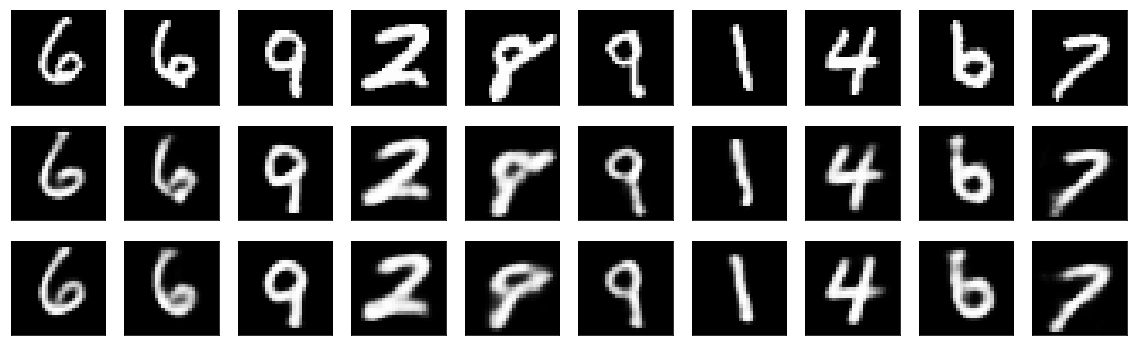

In [43]:
import numpy as np
def plot(data1, recon_batch1, recon_batch2):
    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 6))
    data = data1.data.numpy()
    predict = recon_batch1.data.numpy()
    predict2 = recon_batch2.data.numpy()
    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(data[i][0])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(predict[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display reconstruction
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(predict2[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)        
    plt.show()

model.eval()
temp = model(data_metric_test)
plot(data_metric_test, temp[0], recon_batch_metric_test)
np.save('origin', data_metric_test.data.numpy())
np.save('vanilla', temp[0].data.numpy())
np.save('metric', recon_batch_metric_test.data.numpy())